In [16]:
import json
import math
import os
import pathlib
import re
from collections import defaultdict
import seaborn
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import textstat
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
import pickle
import warnings


In [17]:

def flesch_reading_ease(text):
    # formula=206.835-1.015(total_words/1)-84.6(syllables/total_words)
    syllables=textstat.syllable_count(text)
    words=textstat.lexicon_count(text, removepunct=True)
    score=round(206.835-1.015*(words/1)-84.6*(float(syllables/words)),2)
    # print(score)
    return score

def flesch_kincaid_grade_level(text):
    # formula=0.39*(total_words/1)+11.8(syllables/total_words)-15.59
    syllables=textstat.syllable_count(text)
    words=textstat.lexicon_count(text, removepunct=True)
    score=round(0.39*(words/1)+11.8*(syllables/words)-15.59,2)
    # print(score)
    return score

def total_characters(text):
    count=0
    for char in text:
        count += 1
    return count

#Remove extra white spaces, urls , mentions
def preprocess(text):
    text=text.lower()   
    # print(stopwords)
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
    '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub('#\S+', '', parsed_text)  # remove hashtags
    parsed_text = re.sub('@\S+', '  ', parsed_text)  # remove mentions
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def cleaning(text):
    text=preprocess(text)
    return text
def tokenization_with_stemming(text):
    stemmer=PorterStemmer()
    tokens = [stemmer.stem(t) for t in text.split()]
    # print(tokens)

    return tokens

def tokenize(text):
    text = " ".join(re.split("[^a-zA-Z.,!?]*", text.lower())).strip()
    return text.split()

def set_class(text):
    if text=='NAG':
        return 2
    elif text=='OAG':
        return 1
    else:
        return 0

def preprocessing():
    path = pathlib.Path(__file__).parent.absolute()
    path = str(path)
    #Loading file set to data frame
    df=pd.read_csv(path + "\\trac-gold-set\\agr_en_fb_gold.csv", encoding = "utf-8")
    #Case folding and porter stemming
    # df["preprocess"]=df["text"].apply(lambda x:x.lower())
    df["preprocess"]=df["text"].apply(lambda x:preprocess(x))
    # print(df['preprocess'])
    df["flesch_reading_ease"]=df["text"].apply(lambda x:flesch_reading_ease(x))
    df["flesch_kincaid_grade_level"]=df["text"].apply(lambda x:flesch_kincaid_grade_level(x))
    df["syllables"]=df["text"].apply(lambda x:textstat.syllable_count(x))
    df["words"]=df["text"].apply(lambda x:textstat.lexicon_count(x))
    df["characters"]=df["text"].apply(lambda x:total_characters(x))
    df["class"]=df["aggresssion-level"].apply(lambda x:set_class(x))
    #Export processed CSV
    # print(df.text)
    df.to_csv('processed_data.csv')
    # df.describe()

def features(text):
    sentiment_analyzer=VS()
    sentiment = sentiment_analyzer.polarity_scores(text)
    
    words = preprocess(text) #Get text only
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = flesch_kincaid_grade_level(text)
    ##Modified FRE score, where sentence fixed to 1
    FRE = flesch_reading_ease(text)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(text):
    feats=[]
    for t in text:
        feats.append(features(t))
    return np.array(feats)
    
    
vectorizer = TfidfVectorizer(
    tokenizer=tokenization_with_stemming,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True,
    use_idf=True,
    smooth_idf=True,
    norm=None,
    decode_error='replace',
    max_features=1500,
    lowercase=True,
     token_pattern='[a-zA-Z0-9]+',
     strip_accents='unicode'
    )
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=1500,lowercase=True,
     token_pattern='[a-zA-Z0-9]+',
     strip_accents='unicode'
    
    )

def processing(text):
    tfidf = vectorizer.fit_transform(text).toarray()
    features=get_feature_array(text)

    #Get parts of speech tags for text and save as a string
    text_tag = []
    for t in text:
        tokens = tokenize(preprocess(t))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        tag_str = " ".join(tag_list)
        text_tag.append(tag_str)

    pos = pos_vectorizer.fit_transform(pd.Series(text_tag)).toarray()

    M = np.concatenate([tfidf,pos,features],axis=1)
    return M

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syllables_per_sent", "num_chars", "num_chars_total",
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", 
                        "vader compound"]
stopwords = nltk.corpus.stopwords.words("english")

In [18]:
#DATA READING AND PROCESSING

df=pd.read_csv("Megaset.csv")
text=df.text
#Fit_transform used so nan space is filled with some number
tfidf = vectorizer.fit_transform(text).toarray()
features=get_feature_array(text)

# Get parts of speech tags for text and save as a string
text_tag = []
for t in text:
    tokens = tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tag.append(tag_str)

pos = pos_vectorizer.fit_transform(pd.Series(text_tag)).toarray()

M = np.concatenate([tfidf,pos,features],axis=1)

X=pd.DataFrame(M)
# X=tfidf
# X.to_csv('Xtrain Uni.csv')

C:\Program Files\Python38\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warn

In [20]:
#RUN HERE TO LOAD SAVED DATA FILES
# M=pd.read_csv('Xtrain Uni.csv')
with open(r'F:\IR_Project\k180198 k180182 k180253 Review Sentiment Analysis\asset\tfidf', 'wb') as fin:
    pickle.dump(vectorizer, fin)
with open(r'F:\IR_Project\k180198 k180182 k180253 Review Sentiment Analysis\asset\pos', 'wb') as fin:
    pickle.dump(pos_vectorizer, fin)
# print (M)
df=pd.read_csv("Megaset.csv")
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

In [21]:
print(X_train.shape)
print(X_test.shape)

(19826, 2399)
(4957, 2399)


In [22]:
# select = SelectFromModel(LogisticRegression(solver='newton-cg',class_weight='balanced',penalty="l2",C=0.01))
# X_ = select.fit_transform(X_train,y_train)

In [23]:
model = LogisticRegression(solver='newton-cg',class_weight='balanced',penalty='l2',C=0.01).fit(X_train,y_train)

In [24]:
y_preds = model.predict(X_test)

In [25]:
report = classification_report( y_test, y_preds )

In [26]:
print(report)
import pickle
with open(r'F:\IR_Project\k180198 k180182 k180253 Review Sentiment Analysis\asset\trained_model.pkl', 'wb') as fin:
    pickle.dump(model, fin)

import joblib
joblib.dump(model,r'F:\IR_Project\k180198 k180182 k180253 Review Sentiment Analysis\asset\trained_model_logistic')

              precision    recall  f1-score   support

           0       0.24      0.61      0.34       282
           1       0.97      0.80      0.88      3879
           2       0.71      0.90      0.79       796

    accuracy                           0.81      4957
   macro avg       0.64      0.77      0.67      4957
weighted avg       0.88      0.81      0.83      4957



['F:\\IR_Project\\k180198 k180182 k180253 Review Sentiment Analysis\\asset\\trained_model_logistic']

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
print(confusion_matrix)
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
print(confusion_df)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

[[ 171   72   39]
 [ 511 3116  252]
 [  43   39  714]]
               Hate  Offensive   Neither
Hate       0.606383   0.255319  0.138298
Offensive  0.131735   0.803300  0.064965
Neither    0.054020   0.048995  0.896985


In [28]:
print(X.shape)

(24783, 2399)


array([[<AxesSubplot:title={'center':'class'}>]], dtype=object)

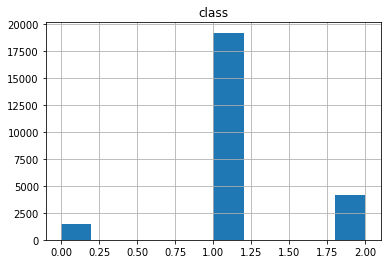

In [19]:
df.hist()